## Домашняя работа №3. Сверточные сети

### Данные

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torchvision as tv
import numpy as np
import time

In [4]:
BATCH_SIZE=256

In [ ]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

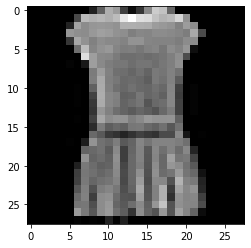

In [8]:
plt.imshow(train_dataset[3][0].numpy().reshape(28,28), cmap='gray')

In [9]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
dev

device(type='cuda')

### Модель

In [51]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 64, kernel_size=5, padding=2),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=2),

    torch.nn.Conv2d(64, 128, kernel_size=5),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, stride=2),
    
    torch.nn.Flatten(),
    torch.nn.Linear(3200, 160),
    torch.nn.BatchNorm1d(160),
    torch.nn.ReLU(),
    torch.nn.Linear(160, 10),
    torch.nn.LogSoftmax(dim=1)
)

In [52]:
model = model.to(dev)

### Обучение

In [53]:
loss = torch.nn.CrossEntropyLoss(reduction='sum')
trainer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for ep in range(num_epochs):
    train_iters, train_passed  = 0, 0
    train_loss, train_acc = 0., torch.Tensor([0]).to(dev)
    start=time.time()
    
    model.train()
    for X, y in train:
        trainer.zero_grad()
        X, y = X.to(dev), y.to(dev)
        y_pred = model(X)
        l = loss(y_pred, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item()
        train_iters += 1
        train_passed += y.shape[0]
    
    test_iters, test_passed  = 0, 0
    test_loss, test_acc = 0., torch.Tensor([0]).to(dev)
    model.eval()
    for X, y in test:
        X, y = X.to(dev), y.to(dev)
        y_pred = model(X)
        l = loss(y_pred, y)
        test_loss += l.item()
        test_acc += (y_pred.argmax(dim=1) == y).sum().item()
        test_iters += 1
        test_passed += y.shape[0]
        
    train_acc_res = (train_acc / train_passed)[0].cpu().numpy()
    test_acc_res = (test_acc / test_passed)[0].cpu().numpy()
    print("ep: {}, taked: {:.3f}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
        ep, time.time() - start, train_loss / train_iters, train_acc_res,
        test_loss / test_iters, test_acc_res)
    )

ep: 0, taked: 19.777, train_loss: 98.30309363831866, train_acc: 0.8687999844551086, test_loss: 74.70639346837997, test_acc: 0.8916999697685242
ep: 1, taked: 19.741, train_loss: 60.57616520333797, train_acc: 0.9145500063896179, test_loss: 64.33366610109806, test_acc: 0.9063999652862549
ep: 2, taked: 21.454, train_loss: 48.343654518939076, train_acc: 0.9315000176429749, test_loss: 67.77647409439086, test_acc: 0.905299961566925
ep: 3, taked: 21.688, train_loss: 38.19518620511319, train_acc: 0.9471333622932434, test_loss: 73.70719460248947, test_acc: 0.8976999521255493
ep: 4, taked: 21.971, train_loss: 29.761317167890834, train_acc: 0.9595666527748108, test_loss: 74.43545504808426, test_acc: 0.9034000039100647
ep: 5, taked: 21.004, train_loss: 23.327276290731227, train_acc: 0.9692000150680542, test_loss: 83.92811245918274, test_acc: 0.8968999981880188
ep: 6, taked: 21.258, train_loss: 19.445674612167032, train_acc: 0.9743166565895081, test_loss: 79.10286875367164, test_acc: 0.9052000045776

**Вывод:** поставленной цели в 89.5% точности модели удалось достичь уже на второй итерации за счет увеличения количества каналов в слоях Conv2d и использования batch-нормализации.